# STATS 507 - Final Project

1. **CNN baseline** using a pretrained ResNet-18 from `torchvision`  
2. **Vision Transformer (ViT)** using a pretrained model from **Hugging Face** (`google/vit-base-patch16-224`)

In [1]:
# import libraries

import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, f1_score, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision.io as io
from torchvision import transforms, models

from transformers import ViTForImageClassification, ViTImageProcessor

# set hyperparameters
# CNN
BATCH_SIZE      = 32
NUM_WORKERS     = 0
LR_CNN_HEAD     = 1e-3
LR_CNN_FINETUNE = 1e-4
EPOCHS_CNN_HEAD = 2
EPOCHS_CNN_FT   = 4

# ViT
LR_VIT_HEAD     = 5e-5
LR_VIT_FINETUNE = 1e-5
EPOCHS_VIT_HEAD = 5
EPOCHS_VIT_FT   = 15

In [2]:
# check device
# use MPS if available, else use CPU (to make training and evaluation faster)
if torch.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"
    
print(f"Using device: {DEVICE}")
    

Using device: mps


## Load dataset and create train/validation/test splits

In [ ]:
# load dataset
csv_path = "data/cards.csv"  # adjust if needed
df = pd.read_csv(csv_path)
df = df.dropna()

print("Full dataframe shape:", df.shape)

# label mapping (str to int)
labels = sorted(df["label"].unique())
label_to_idx = {lbl: i for i, lbl in enumerate(labels)}
num_classes = len(labels)
print("Found", num_classes, "classes")

# create train/validation/test splits
df_train = df[df["dataset"] == "train"].reset_index(drop=True)
df_valid = df[df["dataset"] == "valid"].reset_index(drop=True)
df_test  = df[df["dataset"] == "test"].reset_index(drop=True)

print(f"Train: {len(df_train)}, Valid: {len(df_valid)}, Test: {len(df_test)}")

Full dataframe shape: (8154, 10)
Found 53 classes
Train: 7624, Valid: 265, Test: 265


### Preload Images into RAM (to save time and avoid repeatedly reading from the disk)

In [ ]:
# preload images into RAM
class CardsDataset(Dataset):
    def __init__(self, df_split, label_to_idx):
        self.label_to_idx = label_to_idx
        self.images = []
        self.labels = []

        print("Preloading images into RAM...")
        for i, row in df_split.iterrows():
            img = io.read_image(row["file_path"]) 
            self.images.append(img)
            self.labels.append(self.label_to_idx[row["label"]])

            # progress update (make sure images are loading properly)
            if (i + 1) % 500 == 0:
                print("  Loaded", i+1, "images...")
        print("Done preloading. Total images:", len(self.images))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        y = self.labels[idx]
        return img, y

## CNN Model (ResNet-18)
### Preprocessing

In [ ]:
# ImageNet standard mean and std
cnn_mean = [0.485, 0.456, 0.406]
cnn_std  = [0.229, 0.224, 0.225]

# CNN preprocessing pipeline (convert to float and normalize)
cnn_transform = transforms.Compose([
    transforms.ConvertImageDtype(torch.float32),  
    transforms.Normalize(cnn_mean, cnn_std),
])

# create CNN dataset wrapper class to apply transforms
class CardsDatasetCNN(Dataset):
    def __init__(self, base_dataset, transform=None):
        self.base = base_dataset
        self.transform = transform

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        img, y = self.base[idx]
        if self.transform is not None:
            img = self.transform(img)
        return img, y

# CNN datasets using cached images
base_train = CardsDataset(df_train, label_to_idx)
base_valid = CardsDataset(df_valid, label_to_idx)
base_test  = CardsDataset(df_test,  label_to_idx)

# CNN-specific datasets
cnn_train = CardsDatasetCNN(base_train, transform=cnn_transform)
cnn_valid = CardsDatasetCNN(base_valid, transform=cnn_transform)
cnn_test  = CardsDatasetCNN(base_test,  transform=cnn_transform)

# dataloaders
cnn_train_loader = DataLoader(cnn_train, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=NUM_WORKERS)
cnn_valid_loader = DataLoader(cnn_valid, batch_size=BATCH_SIZE,
                              shuffle=False, num_workers=NUM_WORKERS)
cnn_test_loader  = DataLoader(cnn_test,  batch_size=BATCH_SIZE,
                              shuffle=False, num_workers=NUM_WORKERS)

# quick check on loader speed
start = time.time()
for i, (x, y) in enumerate(cnn_train_loader):
    if i == 5:
        break
print("Time for 5 batches (CNN loader):", time.time() - start, "seconds")

Preloading images into RAM...
  Loaded 500 images...
  Loaded 1000 images...
  Loaded 1500 images...
  Loaded 2000 images...
  Loaded 2500 images...
  Loaded 3000 images...
  Loaded 3500 images...
  Loaded 4000 images...
  Loaded 4500 images...
  Loaded 5000 images...
  Loaded 5500 images...
  Loaded 6000 images...
  Loaded 6500 images...
  Loaded 7000 images...
  Loaded 7500 images...
Done preloading. Total images: 7624
Preloading images into RAM...
Done preloading. Total images: 265
Preloading images into RAM...
Done preloading. Total images: 265
Time for 5 batches (CNN loader): 0.07669305801391602 seconds


### Construct the CNN model

In [ ]:
# construct CNN model (ResNet-18)
def make_cnn(num_classes):
    # load pretrained ResNet-18 model backbone & weights
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model

# initialize CNN model and loss function
cnn_model = make_cnn(num_classes).to(DEVICE)
cnn_criterion = nn.CrossEntropyLoss()

# CNN training/evaluation epoch function
def run_epoch_cnn(model, loader, optimizer=None):
    # set model to train or eval mode (depending on whether optimizer is given)
    if optimizer is None:
        model.eval()
    else:
        model.train()

    # initialize metrics (keep track of loss and accuracy)
    running_loss = 0.0
    correct = 0
    total = 0

    # iterate over data
    for x, y in loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        if optimizer is not None:
            optimizer.zero_grad()

        with torch.set_grad_enabled(optimizer is not None):
            logits = model(x)
            loss = cnn_criterion(logits, y)
            if optimizer is not None:
                loss.backward()
                optimizer.step()

        running_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    # calculate average loss and accuracy
    avg_loss = running_loss / total
    acc = correct / total
    
    # return average loss and accuracy
    return avg_loss, acc

### Train & fine-tune CNN (ResNet-18)

In [ ]:
# store CNN training history
cnn_history = {
    "epoch": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

# train only the final FC layer (freeze all layers except final fully-connected layer)
for p in cnn_model.parameters():
    p.requires_grad = False
for p in cnn_model.fc.parameters():
    p.requires_grad = True

# use Adam optimizer for CNN head training
opt_cnn_head = torch.optim.Adam(
    filter(lambda p: p.requires_grad, cnn_model.parameters()),
    lr=LR_CNN_HEAD,
)

# keep track of best validation accuracy and model state
best_val_acc = 0.0
best_cnn_state = None
epoch_idx = 0

# train
print("=== CNN: training classifier head only ===")

# keep track of time for training
start_head = time.time()

for _ in range(EPOCHS_CNN_HEAD):
    epoch_idx += 1

    train_loss, train_acc = run_epoch_cnn(cnn_model, cnn_train_loader, opt_cnn_head)
    val_loss, val_acc     = run_epoch_cnn(cnn_model, cnn_valid_loader, optimizer=None)

    cnn_history["epoch"].append(epoch_idx)
    cnn_history["train_loss"].append(train_loss)
    cnn_history["train_acc"].append(train_acc)
    cnn_history["val_loss"].append(val_loss)
    cnn_history["val_acc"].append(val_acc)

    print(f"[CNN head] Epoch {epoch_idx:02d} "
          f"train loss={train_loss:.4f} acc={train_acc:.4f} | "
          f"val loss={val_loss:.4f} acc={val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_cnn_state = cnn_model.state_dict()

time_head = time.time() - start_head
print("CNN head training time:", round(time_head, 1), "seconds")

# restore best model from head training
if best_cnn_state is not None:
    cnn_model.load_state_dict(best_cnn_state)



# fine-tune entire network
for p in cnn_model.parameters():
    p.requires_grad = True

opt_cnn_ft = torch.optim.Adam(cnn_model.parameters(), lr=LR_CNN_FINETUNE)

print("\n=== CNN: fine-tuning full network ===")
start_ft = time.time()
for _ in range(EPOCHS_CNN_FT):
    epoch_idx += 1

    train_loss, train_acc = run_epoch_cnn(cnn_model, cnn_train_loader, opt_cnn_ft)
    val_loss, val_acc     = run_epoch_cnn(cnn_model, cnn_valid_loader, optimizer=None)

    cnn_history["epoch"].append(epoch_idx)
    cnn_history["train_loss"].append(train_loss)
    cnn_history["train_acc"].append(train_acc)
    cnn_history["val_loss"].append(val_loss)
    cnn_history["val_acc"].append(val_acc)

    print(f"[CNN ft]   Epoch {epoch_idx:02d} "
          f"train loss={train_loss:.4f} acc={train_acc:.4f} | "
          f"val loss={val_loss:.4f} acc={val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_cnn_state = cnn_model.state_dict()

time_ft = time.time() - start_ft
total_cnn_time = time_head + time_ft

print("CNN fine-tuning time:", round(time_ft, 1), "seconds")
print("Total CNN training time:", round(total_cnn_time, 1), "seconds")
print("Best CNN validation accuracy:", round(best_val_acc, 4))

# load best overall CNN weights
if best_cnn_state is not None:
    cnn_model.load_state_dict(best_cnn_state)

=== CNN: training classifier head only ===
[CNN head] Epoch 01 train loss=2.9789 acc=0.2180 | val loss=2.1498 acc=0.3811
[CNN head] Epoch 02 train loss=2.1519 acc=0.4167 | val loss=1.8638 acc=0.4151
CNN head training time: 37.7 seconds

=== CNN: fine-tuning full network ===
[CNN ft]   Epoch 03 train loss=0.9499 acc=0.7514 | val loss=0.3093 acc=0.9132
[CNN ft]   Epoch 04 train loss=0.2575 acc=0.9481 | val loss=0.2103 acc=0.9472
[CNN ft]   Epoch 05 train loss=0.0901 acc=0.9875 | val loss=0.1366 acc=0.9660
[CNN ft]   Epoch 06 train loss=0.0460 acc=0.9953 | val loss=0.0933 acc=0.9849
CNN fine-tuning time: 217.1 seconds
Total CNN training time: 254.8 seconds
Best CNN validation accuracy: 0.9849


### model CNN test performance and training curves

CNN test loss: 0.1113, CNN test accuracy: 0.9660
Saved CNN model to cards_cnn_resnet18_finetuned.pth
Saved CNN plots: cnn_loss_curve.png, cnn_accuracy_curve.png


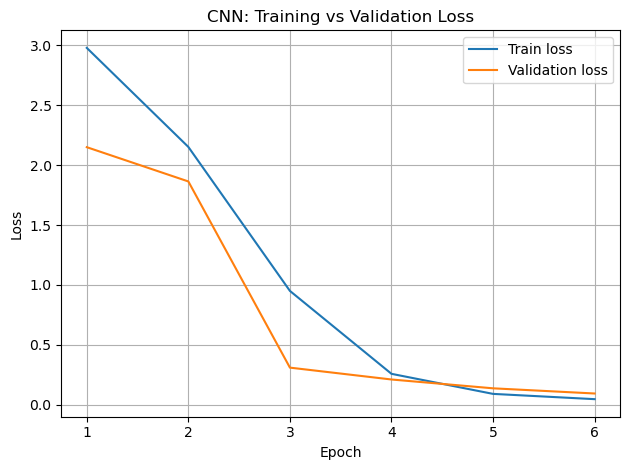

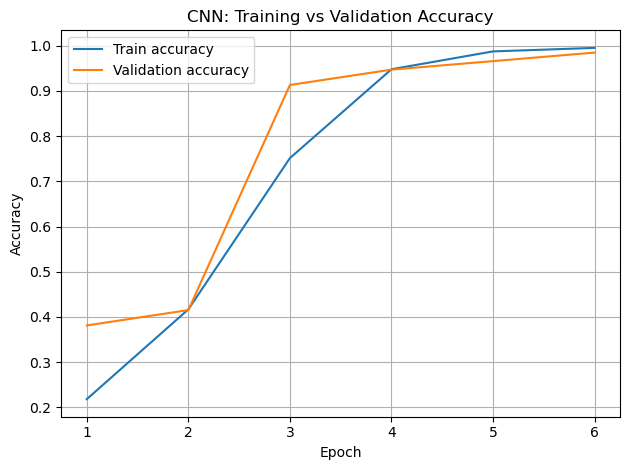

In [ ]:
# evaluate CNN on test set
cnn_test_loss, cnn_test_acc = run_epoch_cnn(cnn_model, cnn_test_loader, optimizer=None)
print(f"CNN test loss: {cnn_test_loss:.4f}, CNN test accuracy: {cnn_test_acc:.4f}")

# save CNN model (including label mapping)
torch.save({
    "model_state_dict": cnn_model.state_dict(),
    "label_to_idx": label_to_idx,
}, "cards_cnn_resnet18_finetuned.pth")
print("Saved CNN model to cards_cnn_resnet18_finetuned.pth")

epochs_cnn = cnn_history["epoch"]

# plot CNN training and validation loss/accuracy curves
plt.figure()
plt.plot(epochs_cnn, cnn_history["train_loss"], label="Train loss")
plt.plot(epochs_cnn, cnn_history["val_loss"],   label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN: Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("cnn_loss_curve.png")

# plot CNN accuracy curves
plt.figure()
plt.plot(epochs_cnn, cnn_history["train_acc"], label="Train accuracy")
plt.plot(epochs_cnn, cnn_history["val_acc"],   label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("CNN: Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("cnn_accuracy_curve.png")

print("Saved CNN plots: cnn_loss_curve.png, cnn_accuracy_curve.png")

## ViT model using Hugging Face (`google/vit-base-patch16-224`)

In [ ]:
# ViT model using Hugging Face (`google/vit-base-patch16-224`)
vit_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")

# create ViT dataset wrapper class to apply Hugging Face processor
class CardsDatasetViT(Dataset):
    def __init__(self, base_dataset):
        self.base = base_dataset

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        img, y = self.base[idx]          # (C,H,W) 
        pil_img = transforms.ToPILImage()(img)
        enc = vit_processor(pil_img, return_tensors="pt")
        pixel_values = enc["pixel_values"].squeeze(0)  # (3, 224, 224)
        return pixel_values, y

# ViT datasets using cached images
vit_train = CardsDatasetViT(base_train)
vit_valid = CardsDatasetViT(base_valid)
vit_test  = CardsDatasetViT(base_test)

# ViT dataloaders
vit_train_loader = DataLoader(vit_train, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=NUM_WORKERS)
vit_valid_loader = DataLoader(vit_valid, batch_size=BATCH_SIZE,
                              shuffle=False, num_workers=NUM_WORKERS)
vit_test_loader  = DataLoader(vit_test,  batch_size=BATCH_SIZE,
                              shuffle=False, num_workers=NUM_WORKERS)

# quick check on ViT loader speed
start = time.time()
for i, (x, y) in enumerate(vit_train_loader):
    if i == 5:
        break
print("Time for 5 batches (ViT loader):", time.time() - start, "seconds")

Time for 5 batches (ViT loader): 0.16724228858947754 seconds


### ViT model and training function

In [ ]:
# get ViT model from Hugging Face
vit_model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=num_classes,
    ignore_mismatched_sizes=True,
).to(DEVICE)

# ViT training/evaluation epoch function
def run_epoch_vit(model, loader, optimizer=None):
    if optimizer is None:
        model.eval()
    else:
        model.train()

    total = 0
    correct = 0
    running_loss = 0.0

    for x, y in loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        if optimizer is not None:
            optimizer.zero_grad()

        with torch.set_grad_enabled(optimizer is not None):
            outputs = model(pixel_values=x, labels=y)
            loss = outputs.loss
            logits = outputs.logits
            if optimizer is not None:
                loss.backward()
                optimizer.step()

        running_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    avg_loss = running_loss / total
    acc = correct / total
    return avg_loss, acc

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([53]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([53, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Train & fine-tune ViT model

In [ ]:
# =====================================================
# 9. Train & fine-tune ViT (with timing)
# =====================================================

# store ViT training history
vit_history = {
    "epoch": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

# train only classifier head
for p in vit_model.parameters():
    p.requires_grad = False
for p in vit_model.classifier.parameters():
    p.requires_grad = True

opt_vit_head = torch.optim.Adam(
    vit_model.classifier.parameters(),
    lr=LR_VIT_HEAD,
)

# keep track of best validation accuracy and model state
best_vit_val_acc = 0.0
best_vit_state = None
vit_epoch_idx = 0

print("=== ViT: training classifier head only ===")
start_vit_head = time.time()
for _ in range(EPOCHS_VIT_HEAD):
    vit_epoch_idx += 1

    train_loss, train_acc = run_epoch_vit(vit_model, vit_train_loader, opt_vit_head)
    val_loss, val_acc     = run_epoch_vit(vit_model, vit_valid_loader, optimizer=None)

    vit_history["epoch"].append(vit_epoch_idx)
    vit_history["train_loss"].append(train_loss)
    vit_history["train_acc"].append(train_acc)
    vit_history["val_loss"].append(val_loss)
    vit_history["val_acc"].append(val_acc)

    print(f"[ViT head] Epoch {vit_epoch_idx:02d} "
          f"train loss={train_loss:.4f} acc={train_acc:.4f} | "
          f"val loss={val_loss:.4f} acc={val_acc:.4f}")

    if val_acc > best_vit_val_acc:
        best_vit_val_acc = val_acc
        best_vit_state = vit_model.state_dict()

time_vit_head = time.time() - start_vit_head
print("ViT head training time:", round(time_vit_head, 1), "seconds")

# get best model state
if best_vit_state is not None:
    vit_model.load_state_dict(best_vit_state)



# fine-tune entire ViT
for p in vit_model.parameters():
    p.requires_grad = True

# use Adam optimizer for ViT fine-tuning
opt_vit_ft = torch.optim.Adam(vit_model.parameters(), lr=LR_VIT_FINETUNE)

print("\n=== ViT: fine-tuning full network ===")
start_vit_ft = time.time()
for _ in range(EPOCHS_VIT_FT):
    vit_epoch_idx += 1

    train_loss, train_acc = run_epoch_vit(vit_model, vit_train_loader, opt_vit_ft)
    val_loss, val_acc     = run_epoch_vit(vit_model, vit_valid_loader, optimizer=None)

    vit_history["epoch"].append(vit_epoch_idx)
    vit_history["train_loss"].append(train_loss)
    vit_history["train_acc"].append(train_acc)
    vit_history["val_loss"].append(val_loss)
    vit_history["val_acc"].append(val_acc)

    print(f"[ViT ft]   Epoch {vit_epoch_idx:02d} "
          f"train loss={train_loss:.4f} acc={train_acc:.4f} | "
          f"val loss={val_loss:.4f} acc={val_acc:.4f}")

    if val_acc > best_vit_val_acc:
        best_vit_val_acc = val_acc
        best_vit_state = vit_model.state_dict()

time_vit_ft = time.time() - start_vit_ft
total_vit_time = time_vit_head + time_vit_ft

print("ViT fine-tuning time:", round(time_vit_ft, 1), "seconds")
print("Total ViT training time:", round(total_vit_time, 1), "seconds")
print("Best ViT validation accuracy:", round(best_vit_val_acc, 4))

# load best overall ViT weights
if best_vit_state is not None:
    vit_model.load_state_dict(best_vit_state)

=== ViT: training classifier head only ===
[ViT head] Epoch 01 train loss=3.8067 acc=0.0738 | val loss=3.5500 acc=0.1057
[ViT head] Epoch 02 train loss=3.4034 acc=0.1554 | val loss=3.2208 acc=0.1547
[ViT head] Epoch 03 train loss=3.1380 acc=0.2227 | val loss=2.9897 acc=0.2189
[ViT head] Epoch 04 train loss=2.9427 acc=0.2631 | val loss=2.8159 acc=0.2264
[ViT head] Epoch 05 train loss=2.7913 acc=0.2992 | val loss=2.6823 acc=0.2830
ViT head training time: 692.2 seconds

=== ViT: fine-tuning full network ===
[ViT ft]   Epoch 06 train loss=2.0977 acc=0.4658 | val loss=1.5455 acc=0.6075
[ViT ft]   Epoch 07 train loss=1.3104 acc=0.7264 | val loss=0.9856 acc=0.7660
[ViT ft]   Epoch 08 train loss=0.8266 acc=0.8585 | val loss=0.6530 acc=0.8755
[ViT ft]   Epoch 09 train loss=0.5246 acc=0.9281 | val loss=0.4637 acc=0.8981
[ViT ft]   Epoch 10 train loss=0.3373 acc=0.9673 | val loss=0.3649 acc=0.9208
[ViT ft]   Epoch 11 train loss=0.2192 acc=0.9845 | val loss=0.3007 acc=0.9283
[ViT ft]   Epoch 12 tr

### model ViT test performance and training curves

ViT test loss: 0.2431, ViT test accuracy: 0.9245
Saved ViT plots: vit_loss_curve.png, vit_accuracy_curve.png
Saved comparison plot: cnn_vs_vit_val_accuracy.png


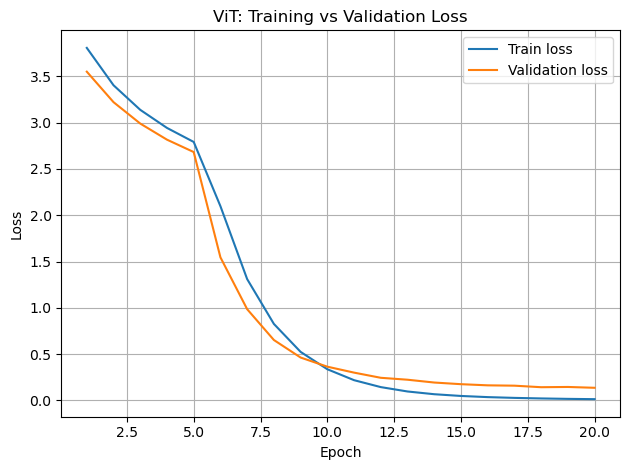

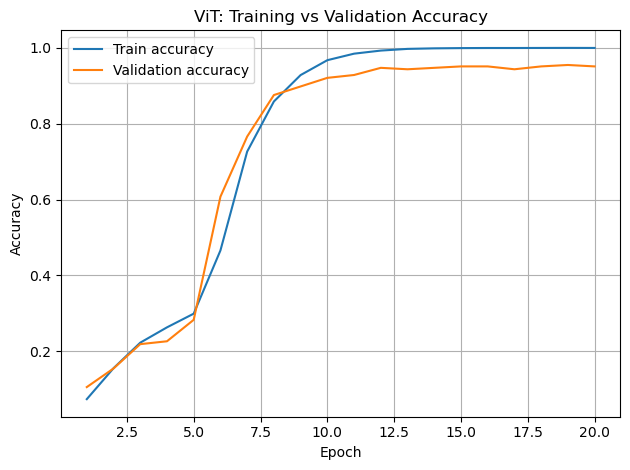

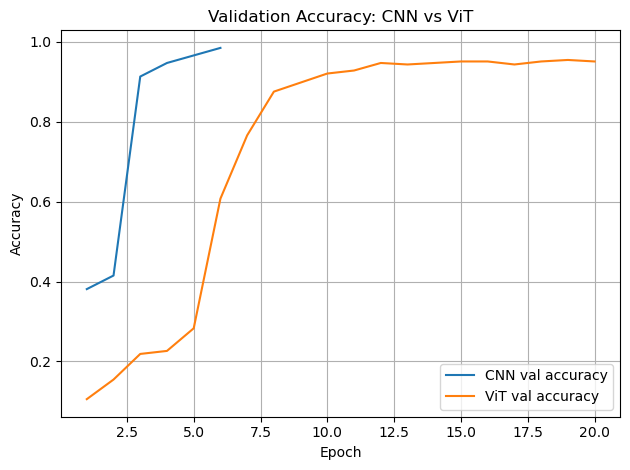

In [ ]:
# evaluate ViT on test set
vit_test_loss, vit_test_acc = run_epoch_vit(vit_model, vit_test_loader, optimizer=None)
print(f"ViT test loss: {vit_test_loss:.4f}, ViT test accuracy: {vit_test_acc:.4f}")

vit_epochs = vit_history["epoch"]

# plot ViT training and validation loss/accuracy curves
plt.figure()
plt.plot(vit_epochs, vit_history["train_loss"], label="Train loss")
plt.plot(vit_epochs, vit_history["val_loss"],   label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ViT: Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("vit_loss_curve.png")

# plot ViT accuracy curves
plt.figure()
plt.plot(vit_epochs, vit_history["train_acc"], label="Train accuracy")
plt.plot(vit_epochs, vit_history["val_acc"],   label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ViT: Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("vit_accuracy_curve.png")

print("Saved ViT plots: vit_loss_curve.png, vit_accuracy_curve.png")

### CNN and ViT Comparison

In [ ]:
# comparison plot: CNN vs ViT validation accuracy
plt.figure()
plt.plot(cnn_history["epoch"], cnn_history["val_acc"], label="CNN val accuracy")
plt.plot(vit_history["epoch"], vit_history["val_acc"], label="ViT val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy: CNN vs ViT")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("cnn_vs_vit_val_accuracy.png")

print("Saved comparison plot: cnn_vs_vit_val_accuracy.png")

=== CNN Classification Report ===
                   precision    recall  f1-score   support

     ace of clubs       1.00      1.00      1.00         5
  ace of diamonds       1.00      1.00      1.00         5
    ace of hearts       1.00      1.00      1.00         5
    ace of spades       0.83      1.00      0.91         5
   eight of clubs       0.83      1.00      0.91         5
eight of diamonds       1.00      1.00      1.00         5
  eight of hearts       1.00      1.00      1.00         5
  eight of spades       1.00      1.00      1.00         5
    five of clubs       1.00      0.60      0.75         5
 five of diamonds       1.00      0.80      0.89         5
   five of hearts       0.83      1.00      0.91         5
   five of spades       1.00      1.00      1.00         5
    four of clubs       0.83      1.00      0.91         5
 four of diamonds       1.00      1.00      1.00         5
   four of hearts       1.00      1.00      1.00         5
   four of spades    

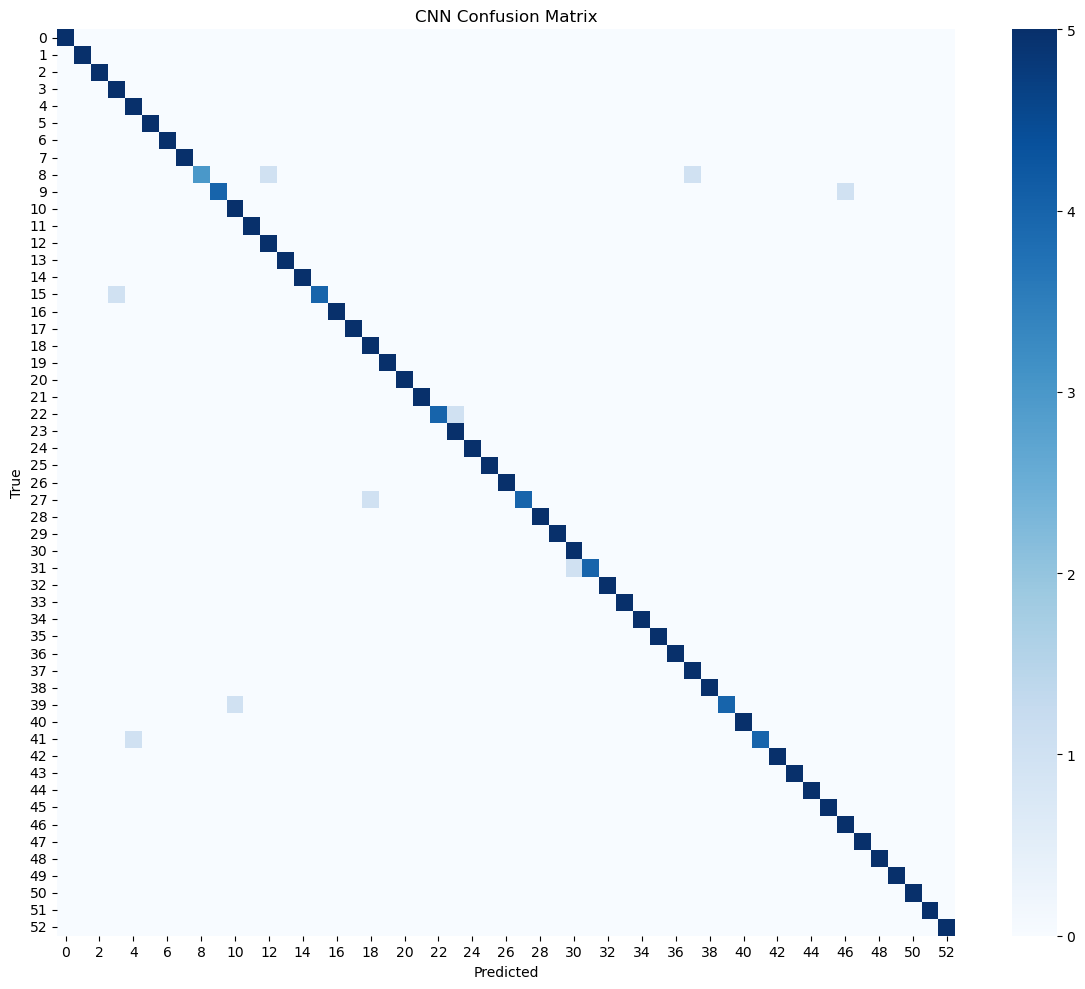


=== ViT Classification Report ===
                   precision    recall  f1-score   support

     ace of clubs       1.00      1.00      1.00         5
  ace of diamonds       1.00      1.00      1.00         5
    ace of hearts       1.00      1.00      1.00         5
    ace of spades       1.00      1.00      1.00         5
   eight of clubs       1.00      1.00      1.00         5
eight of diamonds       0.83      1.00      0.91         5
  eight of hearts       1.00      1.00      1.00         5
  eight of spades       1.00      0.80      0.89         5
    five of clubs       0.57      0.80      0.67         5
 five of diamonds       0.71      1.00      0.83         5
   five of hearts       0.83      1.00      0.91         5
   five of spades       1.00      1.00      1.00         5
    four of clubs       1.00      1.00      1.00         5
 four of diamonds       1.00      1.00      1.00         5
   four of hearts       1.00      0.80      0.89         5
   four of spades   

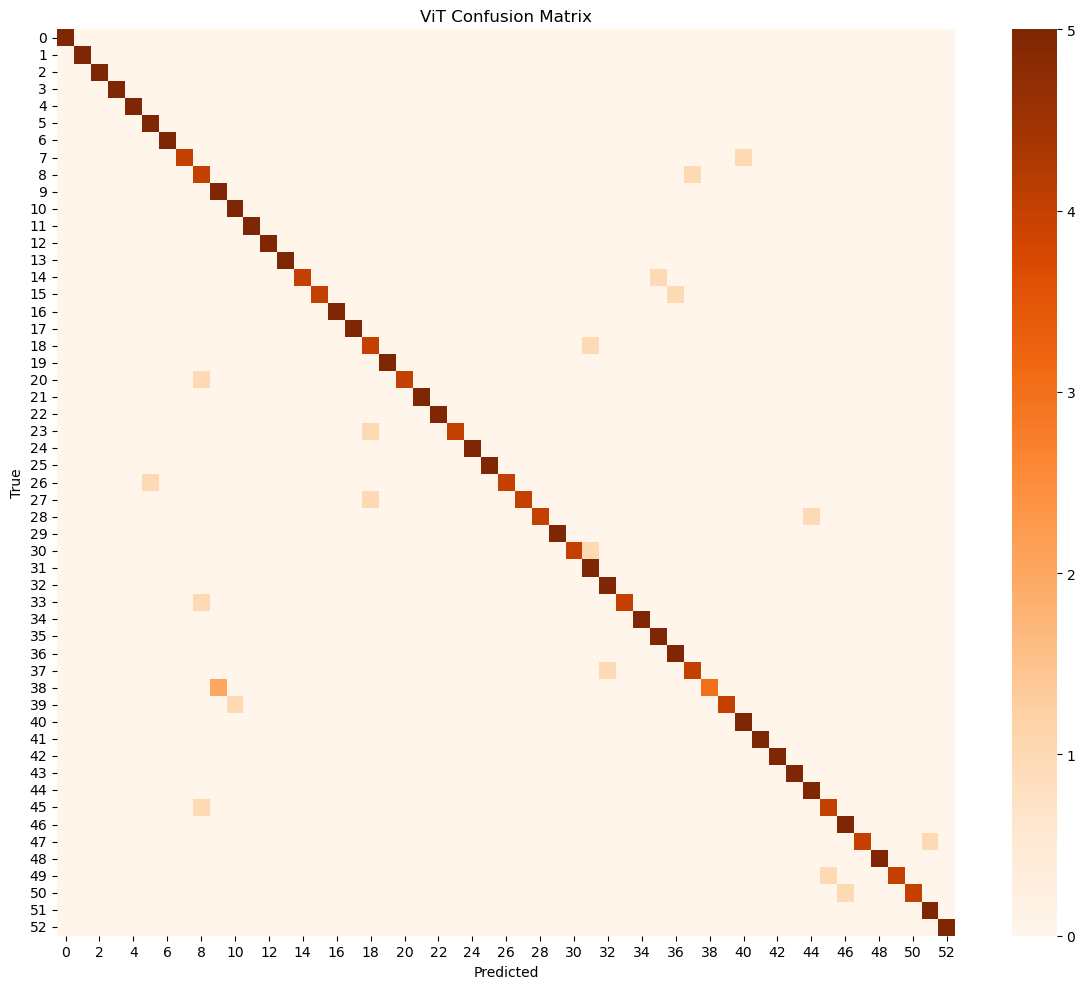

In [ ]:
# compute classification reports and confusion matrices for CNN and ViT

# label mapping
idx_to_label = {v: k for k, v in label_to_idx.items()}

# function to get predictions
def get_predictions(model, loader):
    """Return true labels and predicted labels for a dataloader."""
    model.eval()
    all_preds = []
    all_trues = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            outputs = model(x) if "ResNet" in model.__class__.__name__ else model(pixel_values=x).logits
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_trues.extend(y.cpu().numpy())

    return np.array(all_trues), np.array(all_preds)


# CNN
cnn_true, cnn_pred = get_predictions(cnn_model, cnn_test_loader)

print("=== CNN Classification Report ===")
print(classification_report(cnn_true, cnn_pred, target_names=[idx_to_label[i] for i in range(len(idx_to_label))]))

cnn_macro_f1 = f1_score(cnn_true, cnn_pred, average="macro")
cnn_weighted_f1 = f1_score(cnn_true, cnn_pred, average="weighted")

print("CNN Macro F1:", cnn_macro_f1)
print("CNN Weighted F1:", cnn_weighted_f1)

cnn_cm = confusion_matrix(cnn_true, cnn_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cnn_cm, cmap="Blues", cbar=True)
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("cnn_confusion_matrix.png")
plt.show()



# ViT
vit_true, vit_pred = get_predictions(vit_model, vit_test_loader)

print("\n=== ViT Classification Report ===")
print(classification_report(vit_true, vit_pred, target_names=[idx_to_label[i] for i in range(len(idx_to_label))]))

vit_macro_f1 = f1_score(vit_true, vit_pred, average="macro")
vit_weighted_f1 = f1_score(vit_true, vit_pred, average="weighted")

print("ViT Macro F1:", vit_macro_f1)
print("ViT Weighted F1:", vit_weighted_f1)

vit_cm = confusion_matrix(vit_true, vit_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(vit_cm, cmap="Oranges", cbar=True)
plt.title("ViT Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("vit_confusion_matrix.png")
plt.show()


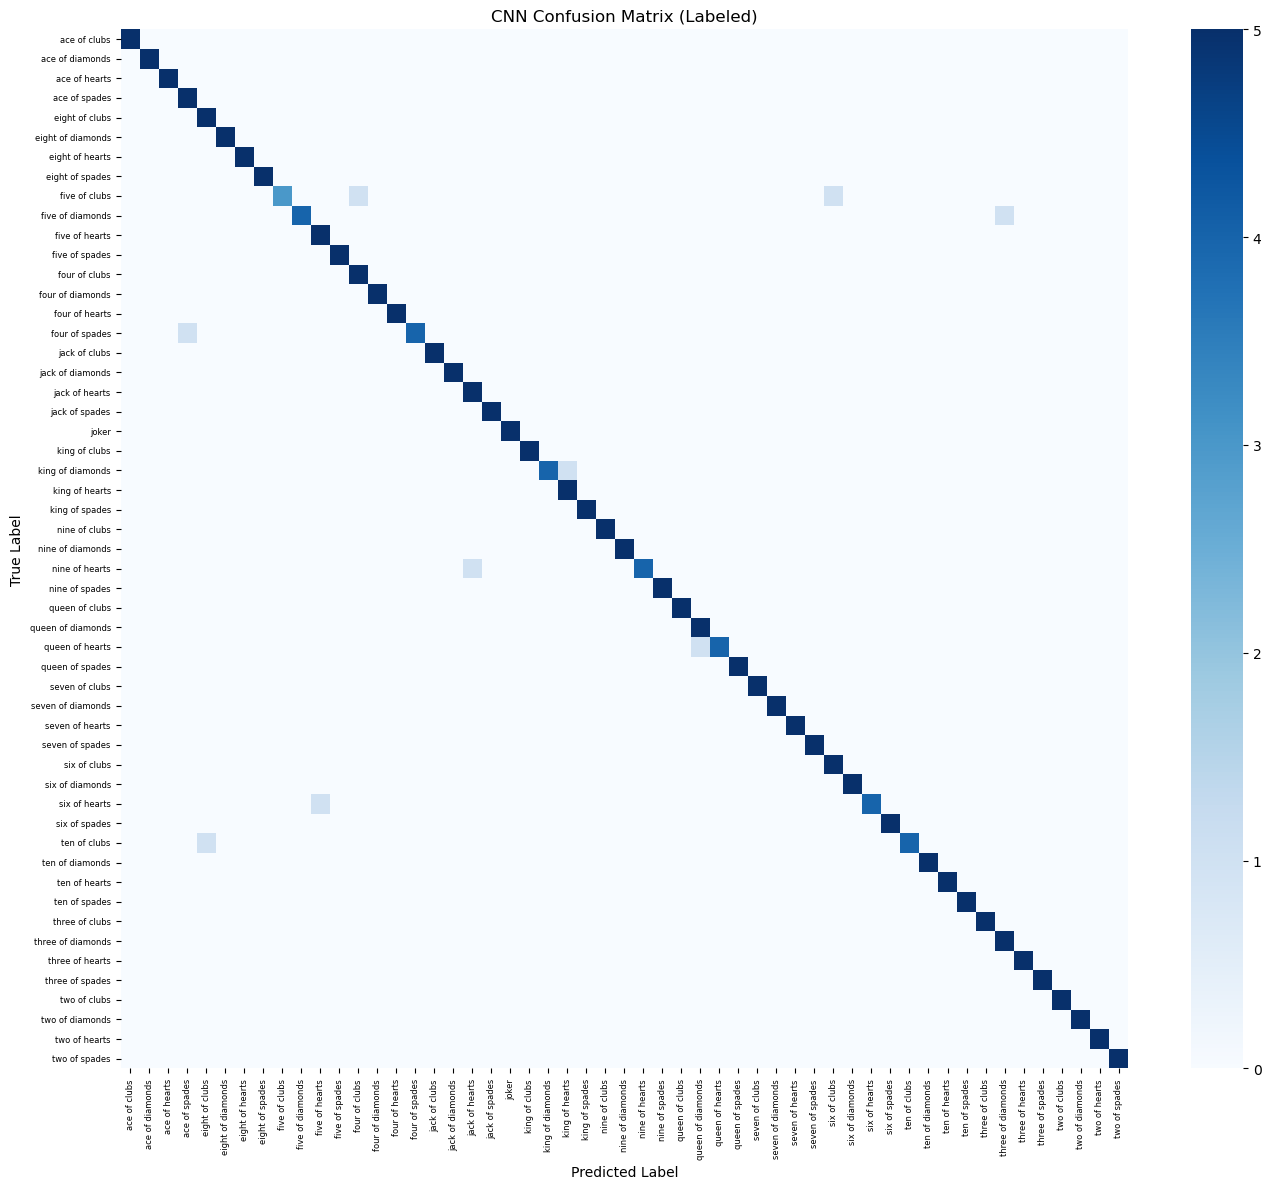

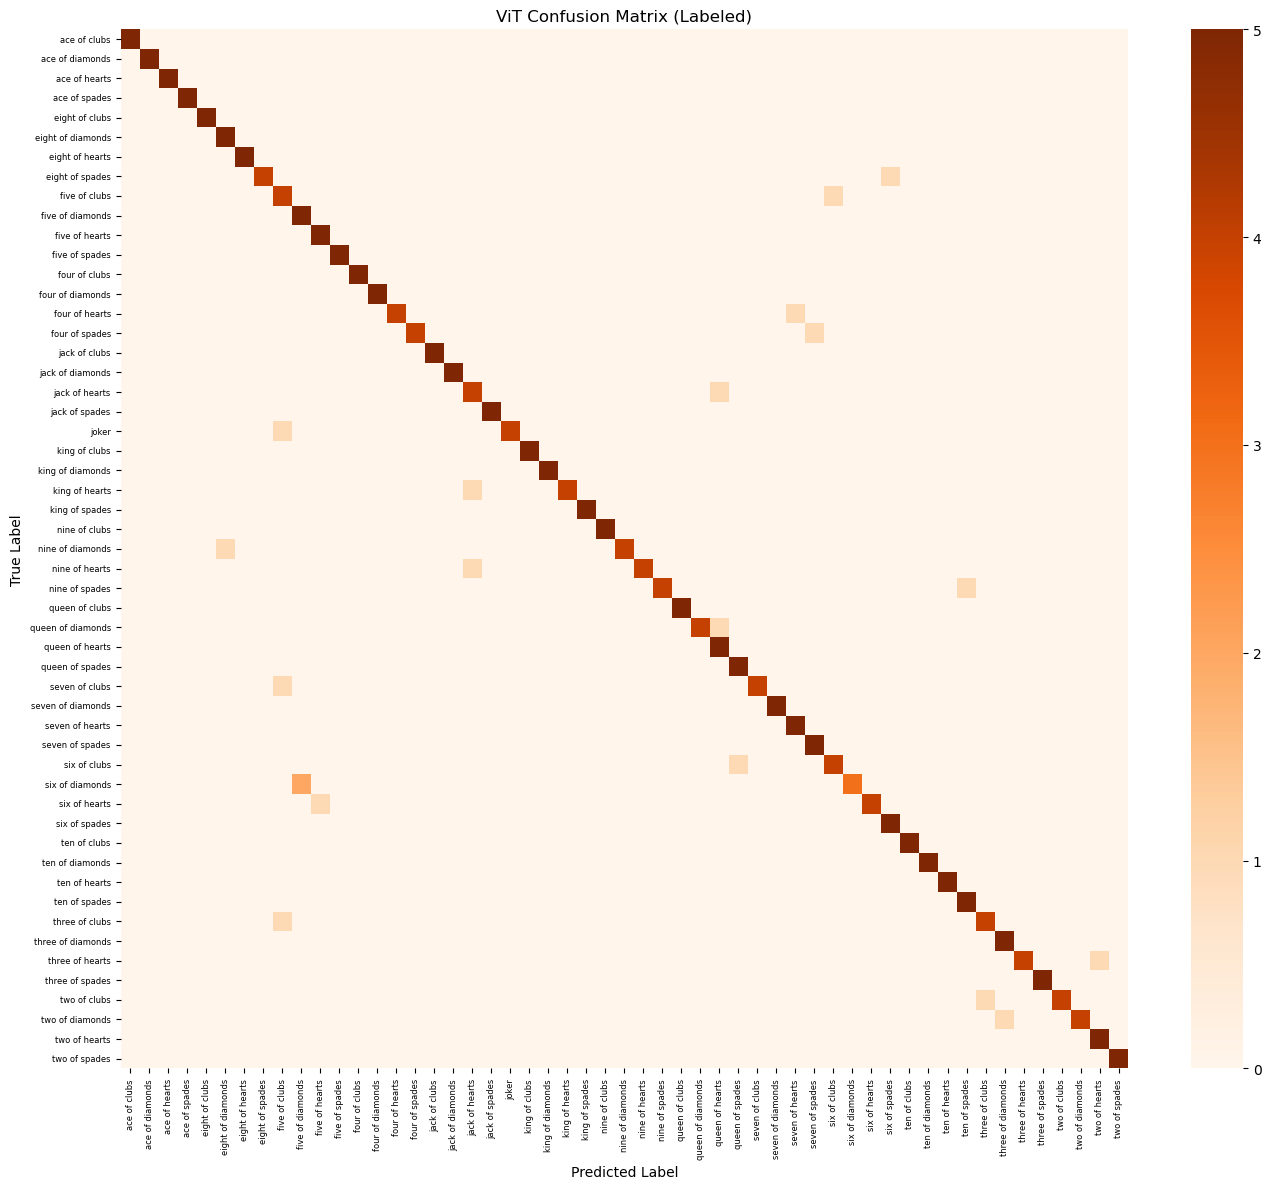

In [ ]:
# for confusion matrix, plot with labeled axes
def plot_confusion_matrix(cm, labels, title, filename, cmap="Blues"):
    plt.figure(figsize=(14, 12))
    sns.heatmap(
        cm,
        annot=False,
        cmap=cmap,
        xticklabels=labels,
        yticklabels=labels
    )
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=90, fontsize=6)
    plt.yticks(rotation=0, fontsize=6)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()


# labels in correct index order
label_list = [idx_to_label[i] for i in range(len(idx_to_label))]

plot_confusion_matrix(cnn_cm, label_list,
                      "CNN Confusion Matrix (Labeled)",
                      "cnn_confusion_matrix_labeled.png",
                      cmap="Blues")

plot_confusion_matrix(vit_cm, label_list,
                      "ViT Confusion Matrix (Labeled)",
                      "vit_confusion_matrix_labeled.png",
                      cmap="Oranges")
